<h1><center>Title of the Project</center></h1>

<h3><center>by Christopher Antar and Shilin Huang</center></h3>

# Table of Contents  
1. [**Introduction**](#intro)
1. <a href='#intro'>Link to the destination'</a>
    1. Motivation
    1. Import Libraries
    1. Some Functions
1. **Data Collection and Preliminary Data Cleaning**
    1. Introduction to the Dataset
    1. Data Cleaning
1. **Data Visualization and Analysis**
    1. Graph 1: the Percentage of Dogs and Cats Adopted   
    1. Graph 2: the Percepntage of Dogs and Dats Adopted for Different Age Groups
    1. Graph 3: the Adoption Percentages by Breed
    1. Graph 4: the Adoption Percentage by Season
1. **Classification**
    1. Process the Data Again
    1. Random Forests
    1. Hypothesis Testing
    1. Graph 5: the 
1. **Conclusion**
    1. Results
    1. Insights

 <a id="intro"></a>

# Introduction
According to the data from [The American Society for the Prevention of Cruelty to Animals® (ASPCA®)](https://www.aspca.org/helping-people-pets/shelter-intake-and-surrender/pet-statistics), approximately 6.3 million companion animals enter U.S. animal shelters nationwide every year and the most common pets are dogs and cats; approximately 4.1 million shelter animals are adopted each year. As animal lovers ourselves, we asked the question, what makes other people love animals so much? This question sparked the motivation for this project, where our goal is to identify what traits make an animal more or less likely to be adopted. 

#### Import Libraries 
We will begin by importing libraries that help data processing, plot making, and classification.  
Here are more information about the libraries we implemened:
* [datetime](https://docs.python.org/3/library/datetime.html): Basic date and time types¶
* [sklearn](https://scikit-learn.org/stable/): Machine Learning in Python
* [matplotlib](https://matplotlib.org): Visualization with Python
* [numpy](https://numpy.org/doc/stable/user/absolute_beginners.html): Numerical Python
* [pandas](https://pandas.pydata.org/docs/user_guide/index.html): data analysis and manipulation tool
* [re](https://docs.python.org/3/library/re.html): Regular Expression
* [warnings](https://docs.python.org/3/library/warnings.html): Warning Control

In [1]:
import datetime as dt
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd 
import re
import warnings
warnings.filterwarnings('ignore')

#### The following functions help us process the data.

This function helps add a new column for age ranges. You need to put the age of the animal in the parameter. The function will return a String indicating the age group of the animal.

In [2]:
def get_age_group(age):
    if age < 90:
        return "0-3 months"
    elif age <=365:
        return "3-12 months"
    elif age <= 731:
        return "1-2 Years"
    elif age <= 1825:
        return "2-5 Years"
    else:
        return "5+ Years"

This function helps change the datetime to corresponding seasons.
You need to put the date with type String in the parameter.
The function will return an integer indicating the season.  
Spring = 1, Summer = 2, Fall = 3, Winter = 4   
We used information on this [website](https://www.timeanddate.com/calendar/aboutseasons.html) to transform dates to seasons

In [3]:
def date_to_season(date):
    month = int(re.compile(r"[0-9]{4}-([0-9]{2})-").match(date).group(1))
    # Spring
    if 3 <= month and month <= 5:
        return 1
    # Summer
    elif 6 <= month and month <= 8:
        return 2
    # Fall
    elif 9 <= month and month <= 11:
        return 3
    # Winter
    elif month == 12 or month == 1 or month == 2:
        return 4

 <a id="9"></a> <br>
# Data Collection and Preliminary Data Cleaning

#### Introduction to the dataset
We found the dataset used for this project on [Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes), which collected data outcomes from the [Austin Animal Center](https://www.austintexas.gov/austin-animal-center) from October 1st, 2013 to March 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In [4]:
# read in the dataset
df = pd.read_csv("train.csv", index_col = 0)
display(df)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
...,...,...,...,...,...,...,...,...,...
A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan


For each animal in this dataset, we are given the following:  
* Unique Animal ID
* Name
* Date of Adoption
* Outcome Type: Adoption, Transfer, Return to Owner, Died, or Euthanasia
* Outcome Subtype
* Animal Type: dog or cat
* Sex
* Age
* Breed
* Color

#### Data Cleaning
We decided that the Name and Outcome Subtype were not useful in testing our hypothesis so we dropped both of those columns immediately. The column that had the Outcome (if they were adopted) data had five possible values. These values were `Adopted, Transfer, Return to Owner, Euthanized`, and `Died`. We came to the conclusion that the `Return to Owner` and `Died` values were not fair to label as either adopted or not adopted, so we dropped any rows that had these values as their result. We felt that the only values that we should count as the animal not being adopted were `Euthanized` or `Transfer`. Therefore we created a new column called `Adopted`, and gave an int value of 1 to any animal that was had `Adopted` in their Outcome column, and 0 to `Euthanized` or `Transfer` values. 

In [5]:
# remove unnecessary columns and rows
df.drop("Name", axis = 1, inplace=True)
df.drop("OutcomeSubtype", axis = 1, inplace=True)
df.drop(df[df.OutcomeType == "Died"].index, inplace=True)
df.drop(df[df.OutcomeType == "Return_to_owner"].index, inplace=True)

# add a column to show whether the animal was adopted, 1 indicates True and 0 indicates False
df["Adopted"] = df.apply(lambda row: 1 if row["OutcomeType"] == "Adoption" else 0 , axis=1)

The column that represented the animal's age was in terms of days, weeks, months, or years. To make calculations easier for us down the line, we transformed all of these values to just be represented in terms of days. We also created a separate `Age Group` column that took each animal's age and put them into a bin of `0-3 months`, `3-12 months`, etc. The purpose of this was also for easier calculations when we decide to visualize the data later in the project.  
????

In [6]:
# change column names
df.rename({"AgeuponOutcome": "AgeuponOutcome(day)"}, axis=1, inplace=True)
df.rename({"DateTime": "Season"}, axis=1, inplace=True)

# iterate through the dataframe to process the data
for index, row in df.iterrows():
    
    # change datetime to season
    # Spring = 1, Summer = 2, Fall = 3, Winter = 4
    df.at[index,"Season"] = date_to_season(row["Season"])
    
    
    # change age to days, assume there are 365 days in a year and 30 days in a month.
    try:
        num = int(re.compile(r"[0-9]+").match(row["AgeuponOutcome(day)"]).group(0))
        
        if "year" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = int(num * 365)
        elif "month" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num * 30
        elif "week" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num * 7
        elif "day" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num
    except:
        df = df.drop(labels=index, axis=0)
        
        # there are about 20 missing data
        
# Create age bins
df['AgeGroup'] = df["AgeuponOutcome(day)"].apply(get_age_group)

In [7]:
# show the cleaned dataframe
display(df)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A656520,3,Euthanasia,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,0,3-12 months
A686464,4,Adoption,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,1,1-2 Years
A683430,2,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,0,0-3 months
A667013,3,Transfer,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,0,1-2 Years
A677334,1,Transfer,Dog,Intact Female,30,Cairn Terrier/Chihuahua Shorthair,Black/Tan,0,0-3 months
...,...,...,...,...,...,...,...,...,...
A702446,1,Transfer,Cat,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,0,0-3 months
A718934,4,Transfer,Cat,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,0,3-12 months
A698128,1,Adoption,Dog,Neutered Male,1460,Old English Bulldog Mix,White/Tan,1,2-5 Years


The next step was to separate the animals by their species. This dataset only included "Cats" and "Dogs", and every row was either Labeled `Cat` or `Dog` with no missing data or other values. Thus, we could create two new dataframes, `cats` and `dogs`, with the groupby function. 

In [8]:
# create seperate dataframes for dogs and cats
grouped = df.groupby(df.AnimalType)
dogs = grouped.get_group("Dog")
cats = grouped.get_group("Cat")

### Data Cleaning for Dogs  and Cats
The final step to clean the data was to deal with the `Breed` column for the dogs dataframe. When looking at the value counts for the Breed column there are `1123` different breeds listed. The reason for this is because many dogs who are put up for adoption are Mutts, and adoption centers will label them as a “Mix” between two very popular dog breeds in order for people to be more likely to adopt them, even though the true breed of the dog is unknown.  
To handle this, we created a regular expression that looks for two breeds with a `“/”` in between them, and replaces that value with `“Mutt”`. After replacing these values, we cut down the total number of Breeds to `277`, which is much more reasonable to work with. 

In [9]:
print("number of dog breeds before we clean the data:", len(dogs['Breed'].value_counts()))

number of dog breeds before we clean the data: 1123


In [10]:
dogs['Breed'] = dogs.Breed.str.replace(r'(^.*/.*$)', 'Mutt', regex=True)
print("number of dog breeds after we clean the data:",len(dogs['Breed'].value_counts()))

number of dog breeds after we clean the data: 277


In [11]:
display(dogs)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A686464,4,Adoption,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,1,1-2 Years
A667013,3,Transfer,Dog,Neutered Male,730,Mutt,Tan,0,1-2 Years
A677334,1,Transfer,Dog,Intact Female,30,Mutt,Black/Tan,0,0-3 months
A671784,4,Adoption,Dog,Spayed Female,150,American Pit Bull Terrier Mix,Red/White,1,3-12 months
A677747,1,Adoption,Dog,Spayed Female,365,Cairn Terrier,White,1,3-12 months
...,...,...,...,...,...,...,...,...,...
A708833,2,Adoption,Dog,Spayed Female,60,Pointer Mix,Black/White,1,0-3 months
A697158,1,Adoption,Dog,Neutered Male,60,Newfoundland Mix,White/Black,1,0-3 months
A701044,1,Adoption,Dog,Neutered Male,60,Mutt,Black/Tricolor,1,0-3 months


In [12]:
print("number of cat breeds:", len(cats['Breed'].value_counts()))

number of cat breeds: 57


There are not too many breeds for cats, so we do not need to clean the dataframe for cats so far.

In [13]:
display(cats)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A656520,3,Euthanasia,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,0,3-12 months
A683430,2,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,0,0-3 months
A699218,1,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Tabby,0,0-3 months
A701489,1,Transfer,Cat,Unknown,21,Domestic Shorthair Mix,Brown Tabby,0,0-3 months
A668402,4,Transfer,Cat,Unknown,730,Domestic Shorthair Mix,Black,0,1-2 Years
...,...,...,...,...,...,...,...,...,...
A687056,2,Transfer,Cat,Intact Male,150,Domestic Shorthair Mix,Orange Tabby,0,3-12 months
A702446,1,Transfer,Cat,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,0,0-3 months
A718934,4,Transfer,Cat,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,0,3-12 months


 <a id="2"></a> <br>
# Data Visualization and Analysis

 <a id="3"></a> <br>
## Graph 1: the Percentage of Dogs and Cats Adopted

We can see that 6497 dogs were adopted, and 4761 were not.
We can see that 4272 cats were adopted, and 6198 were not.


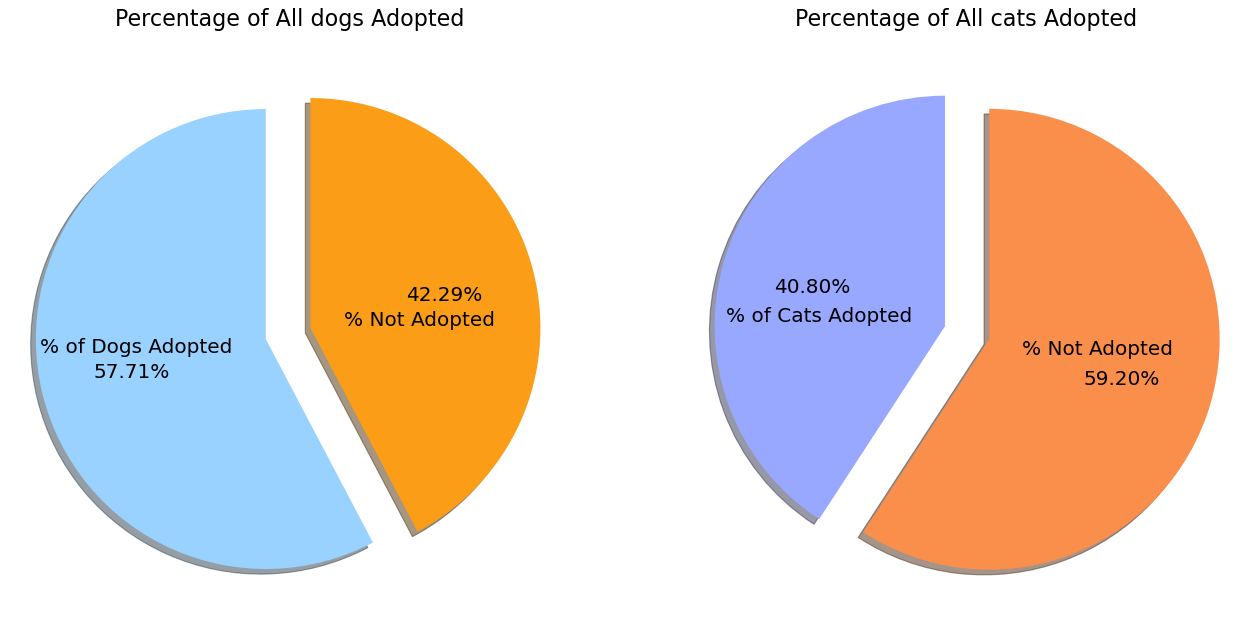

In [14]:
adopt_dog = dogs["Adopted"].value_counts()
print("We can see that", adopt_dog[1] , "dogs were adopted, and", 
      adopt_dog[0], "were not.")

adopt_cat = cats["Adopted"].value_counts()
print("We can see that", adopt_cat[1], "cats were adopted, and", 
            adopt_cat[0], "were not.")

figure(figsize=(20, 10), dpi=80)
   
#Dogs vs Cats Pie Charts
    
# plot for dogs
labels= ['% of Dogs Adopted', '% Not Adopted']
sizes = [adopt_dog[1], adopt_dog[0]]
ax = plt.subplot(1,2,1)
plt.pie(sizes,labels=labels, colors=["#99d1ff", "#fc9d17"], startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%', 
        textprops={'fontsize': 18}, labeldistance= 0.15)
plt.title('Percentage of All dogs Adopted', fontsize = '20')
plt.axis('equal')

# plot for cats
labels= ['% of Cats Adopted', '% Not Adopted']
sizes = [adopt_cat[1], adopt_cat[0]]
ax = plt.subplot(1,2,2)
plt.pie(sizes,labels=labels, colors=["#99a8ff", "#fa8e4b"], startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%', 
        textprops={'fontsize': 18}, labeldistance= 0.15)
plt.title('Percentage of All cats Adopted', fontsize = '20')
plt.axis('equal')

plt.show()

The purpose of this first graph is to settle a lifelong debate of who is the better pet, cats or dogs. So we decided to test the overall adoption rate of cats vs. the adoption rate of dogs, regardless of any other features of the animal. From the pie charts generated, we can see that overall, dogs have a $57.71\%$ adoption rate, whereas cats are adopted at a $40.8\%$ adoption rate. This is a huge difference!

 <a id="4"></a> <br>
## Graph 2: the Percepntage of Dogs and Dats Adopted for Different Age Groups

The next Feature we decided to test was age. By using the `Age Group` column we previously created when cleaning the data, we could separate all of the animals into age groups to see which group had the highest adoption rate. This made this process very straightforward. We generalized cats and dogs that were `1-3 months old` as `puppies/kittens`, `3-12 months old` as `teenagers`, `1-2 years old` as `full grown but still very young`, `2-5 years old` as `adults`, and any animal `over 5 years old` was considered `old`. 


In [15]:
#Create bins for dogs 
dogs['AgeGroup'] = dogs["AgeuponOutcome(day)"].apply(get_age_group)
#This is out of order because value counts will go be highest number
dog_age_groups = ["3-12 months",  "1-2 Years", "2-5 Years", "0-3 months",  "5+ Years"]
age_groups_in_order = ["0-3 months", "3-12 months",  "1-2 Years", "2-5 Years", "5+ Years"]
dog_age_group_totals = dogs['AgeGroup'].value_counts().tolist()
dpercentages = [0] * 5

for i in range(5):
    adopted = len(dogs[(dogs['Adopted'] == 1) & (dogs['AgeGroup'] == dog_age_groups[i] )])
    dpercentages[i] = float(adopted / dog_age_group_totals[i])
dog_percentages_in_order = [dpercentages[3],dpercentages[0],dpercentages[1],dpercentages[2],dpercentages[4]]

In [16]:
#Create bins for cats 
cats['Age Group'] = cats["AgeuponOutcome(day)"].apply(get_age_group)
# This is out of order because value counts will go be highest number
cat_age_groups = ["0-3 months", "3-12 months",  "1-2 Years", "5+ Years", "2-5 Years"]
cat_age_group_totals = cats['Age Group'].value_counts().tolist()
cpercentages = [0] * 5

for i in range(5):
    adopted = len(cats[(cats['Adopted'] == 1) & (cats['AgeGroup'] == cat_age_groups[i] )])
    cpercentages[i] = float(adopted / cat_age_group_totals[i])
cat_percentages_in_order = [cpercentages[3],cpercentages[0],cpercentages[1],cpercentages[2],cpercentages[4]]

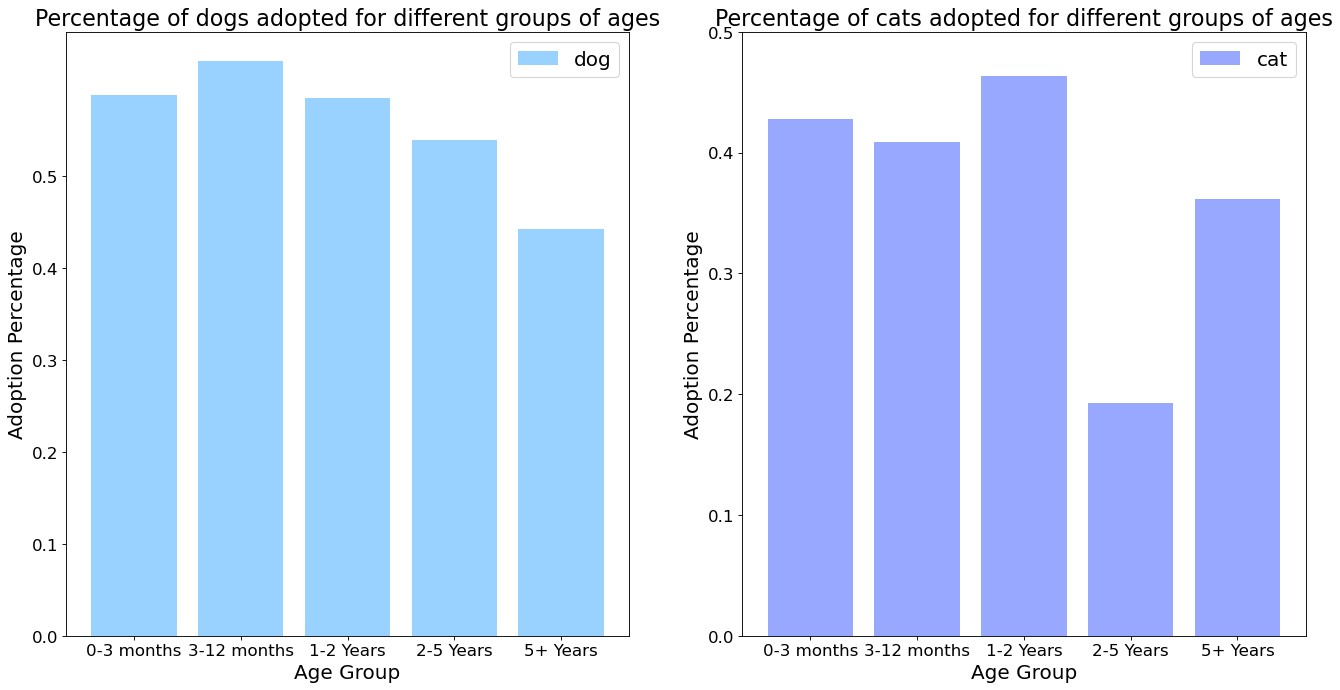

In [17]:
#Dogs vs Cats Bar Charts
figure(figsize=(20, 10), dpi=80)

# plot for dogs
ax = plt.subplot(1,2,1)
plt.bar(age_groups_in_order, dog_percentages_in_order, color = "#99d1ff")
plt.title('Percentage of dogs adopted for different groups of ages', fontsize = '20')
plt.xlabel('Age Group', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.6, 0.1)
plt.xticks(fontsize = '15')
plt.yticks(listOf_Yticks, fontsize = '15')

plt.legend(["dog"], fontsize=18)

# plot for cats
ax = plt.subplot(1,2,2)
plt.bar(age_groups_in_order, cat_percentages_in_order, color = "#99a8ff")
plt.title('Percentage of cats adopted for different groups of ages', fontsize = '20')
plt.xlabel('Age Group', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.6, 0.1)
plt.xticks(fontsize = '15')
plt.yticks(listOf_Yticks, fontsize = '15')
plt.legend(["cat"], fontsize=18)

plt.show()

As expected, we see a general negative relationship between age and adoption rate for dogs, but what was unexpected is that there is not the same type of relationship for cats.
People are much more likely to adopt a younger animal in most scenarios. However, what was not expected, was that dogs who were 0-3 months old had a lower adoption rate than dogs that were 3-12 months old. Our prediction was that puppies would have the highest adoption rate, but they have the second highest adoption rate instead.   
Additionally, we can see that the most popular age range of cats that were adopted were 1-2 years old, beating the 0-3 month old kittens by around $5\%$. We can also see that cats from ages 2-5 years old had the lowest adoption rate of less than $20\%$. Considering cats that are over 5 years old had an adoption rate close to $40\%$, this weakens the strength of the negative relationship between age and adoption rate for cats. 

## Graph 3: the Adoption Percentages by Breed

The penultimate trait that we wanted to test without any regard for other factors was the breed of the animals. Even with previous cleaning, we had 277 breeds of dogs. The issue with this was that there were many Breeds of dogs that only had one or two data points, which would lead to ridiculous results such as $100\%$ adoption rates or $0\%$ adoption rates. Therefore we only counted the top fifteen dog breeds in terms of size, and each breed had at least 100 data points in the data frame. This allowed us to create much more reasonable conclusions. A similar procedure was done with the cats data frame, and we only took the top 9 most popular cat breeds in order to achieve realistic results. 

In [18]:
# Dog breeds
print(dogs['Breed'].value_counts())

Mutt                                  2382
Chihuahua Shorthair Mix               1346
Pit Bull Mix                          1303
Labrador Retriever Mix                 990
German Shepherd Mix                    408
                                      ... 
Nova Scotia Duck Tolling Retriever       1
Norfolk Terrier                          1
Hovawart Mix                             1
American Eskimo                          1
Beauceron                                1
Name: Breed, Length: 277, dtype: int64


We are going to take the 15 most popular dog breeds and calculate their adoption percentage.
From the value counts the following breeds are the most popular dogs, each with over 100 rows of points in the table.

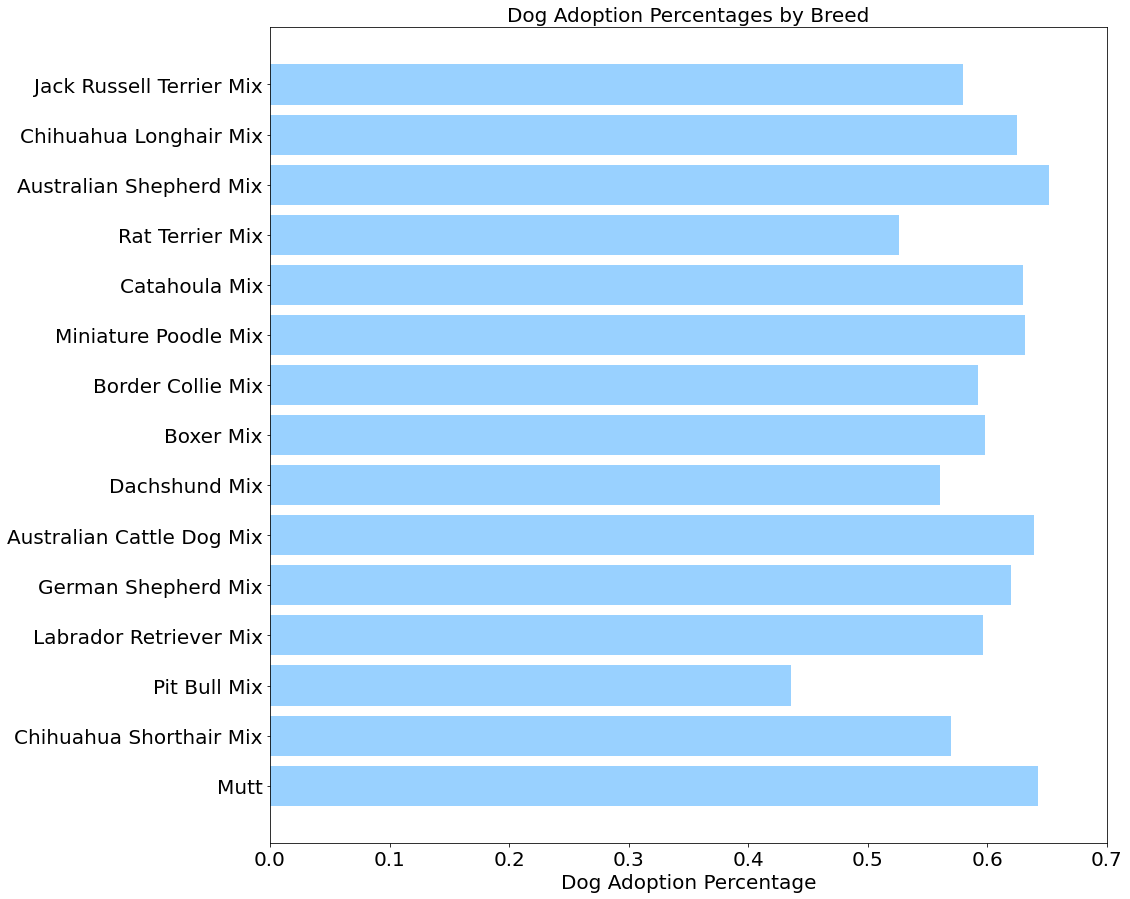

In [19]:
# make a plot
dog_breeds = ["Mutt","Chihuahua Shorthair Mix","Pit Bull Mix","Labrador Retriever Mix","German Shepherd Mix",
          "Australian Cattle Dog Mix","Dachshund Mix","Boxer Mix","Border Collie Mix","Miniature Poodle Mix","Catahoula Mix",
          "Rat Terrier Mix","Australian Shepherd Mix","Chihuahua Longhair Mix","Jack Russell Terrier Mix"]
dog_breed_totals = dogs['Breed'].value_counts().tolist()
dog_breed_totals = dog_breed_totals[0:15]
dog_breed_adoption_percentages = [0] * 15

# Calculating adoption percentages for breeds
for i in range(15):
    adopted = len(dogs[(dogs['Adopted'] == 1) & (dogs['Breed'] == dog_breeds[i])])
    dog_breed_adoption_percentages[i] = float(adopted / dog_breed_totals[i])

plt.figure(figsize=(15,15)) 
plt.barh(np.arange(len(dog_breeds)), dog_breed_adoption_percentages, align='center',color=["#99d1ff"])
plt.yticks(np.arange(len(dog_breeds)), labels=dog_breeds, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Dog Adoption Percentage', fontsize=20)
plt.title('Dog Adoption Percentages by Breed', fontsize=20)
listOf_Xticks = np.arange(0, 0.8, 0.1)
plt.xticks(listOf_Xticks)

plt.show()

When analyzing the bar charts we created, we can see that the most successful dog breed in terms of adoption rate was actually the Mutts. At first take, this might seem surprising, but it makes sense when taking into account that these dogs were not labeled mutts when they were put up for adoption. As mentioned before, most adoption centers lie about the breed of unknown dogs and label them as popular dog breeds so the dogs will be more likely to be adopted. Therefore this result is not that surprising. The least popular breed was a Pit Bull Mix, with an adoption rate slightly above $40\%$.

In [20]:
# Cat breeds
print(cats['Breed'].value_counts())

Domestic Shorthair Mix                     8330
Domestic Medium Hair Mix                    802
Domestic Longhair Mix                       459
Siamese Mix                                 357
Domestic Shorthair                          128
Snowshoe Mix                                 70
Domestic Medium Hair                         42
Manx Mix                                     41
Maine Coon Mix                               40
Russian Blue Mix                             24
Siamese                                      24
Domestic Longhair                            23
Himalayan Mix                                12
Siamese/Domestic Shorthair                   11
Persian Mix                                  11
Ragdoll Mix                                  10
American Shorthair Mix                        8
Angora Mix                                    6
Japanese Bobtail Mix                          6
Balinese Mix                                  5
Bombay Mix                              

For cats, we will only take the 9 most popular cat breeds and calculate their adoption percentage, because we want to have at least 40 rows of data to make our analysis more reliable.

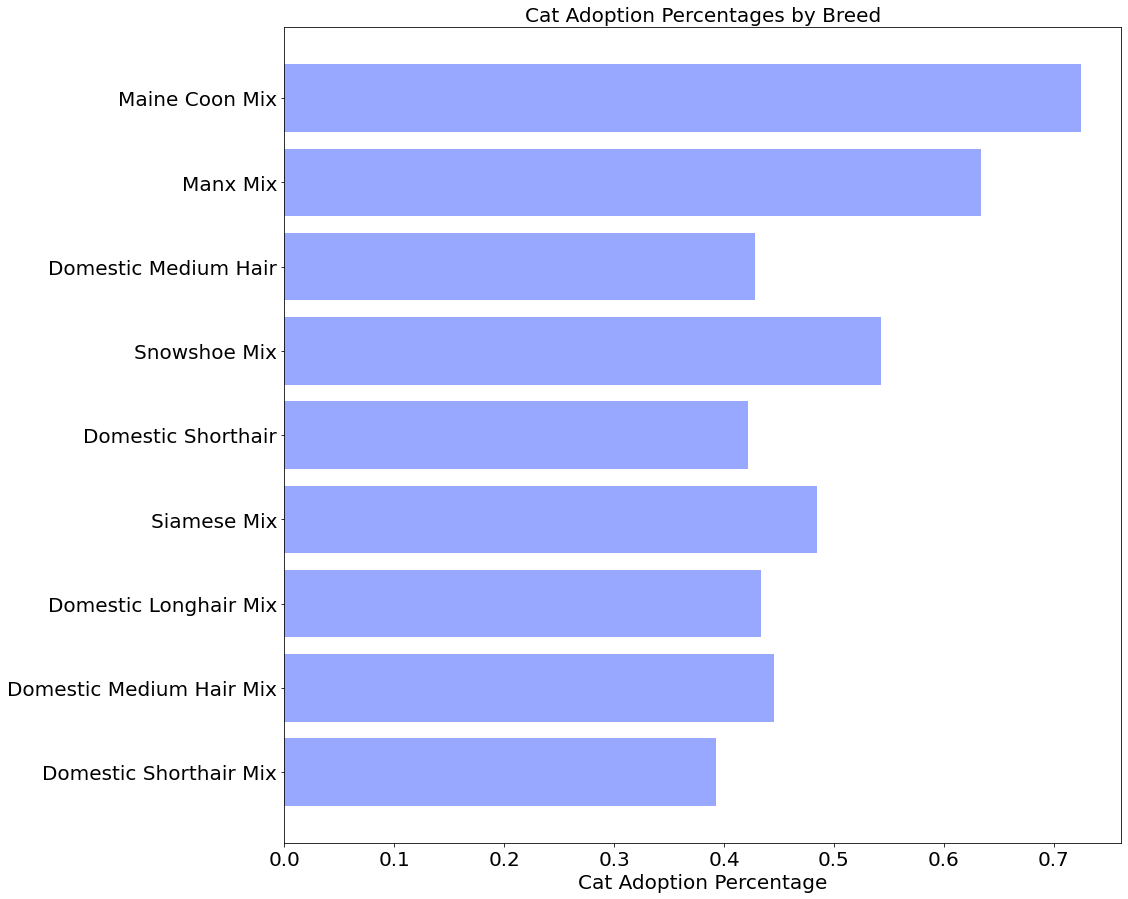

In [21]:
# make a plot
cat_breeds = ["Domestic Shorthair Mix", "Domestic Medium Hair Mix", "Domestic Longhair Mix", "Siamese Mix",
              "Domestic Shorthair", "Snowshoe Mix", "Domestic Medium Hair", "Manx Mix", "Maine Coon Mix"]
cat_breed_totals = cats['Breed'].value_counts().tolist()
cat_breed_totals = cat_breed_totals[0:9]
cat_breed_adoption_percentages = [0] * 9

# Calculating adoption percentages for breeds
for i in range(9):
    adopted = len(cats[(cats['Adopted'] == 1) & (cats['Breed'] == cat_breeds[i])])
    cat_breed_adoption_percentages[i] = float(adopted / cat_breed_totals[i])

plt.figure(figsize=(15,15)) 
plt.barh(np.arange(len(cat_breeds)), cat_breed_adoption_percentages, align='center',color=["#99a8ff"])
plt.yticks(np.arange(len(cat_breeds)), labels=cat_breeds, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Cat Adoption Percentage', fontsize=20)
plt.title('Cat Adoption Percentages by Breed', fontsize=20)
listOf_Xticks = np.arange(0, 0.8, 0.1)
plt.xticks(listOf_Xticks)

plt.show()

The Maine Coon Mix was the most popular cat breed to be adopted, with an adoption rate over $70\%$. This was significantly higher than any adoption rate for a specific breed, dog or cat, with the next highest adoption percentage for cats being the Manx Mix, with a percentage around $60\%$.

## Graph 4: the Adoption Percentage by Season

In [22]:
#Getting Percentages for dogs
dog_seasons = [4,  3, 2, 1]
dog_season_totals = dogs['Season'].value_counts().tolist()
dpercentages = [0] * 4

for i in range(4):
    adopted = len(dogs[(dogs['Adopted'] == 1) & (dogs['Season'] == dog_seasons[i])])

    dpercentages[i] = float(adopted / dog_season_totals[i])

In [23]:
#Getting percentages for cats   
#This is out of order because value counts will go be highest number
cat_seasons = [2, 3, 4, 1]
cat_season_totals = dogs['Season'].value_counts().tolist()
cpercentages = [0] * 4

for i in range(4):
    adopted = len(cats[(cats['Adopted'] == 1) & (cats['Season'] == cat_seasons[i])])
    cpercentages[i] = float(adopted / cat_season_totals[i])
#Re-order to fir original seasons
updated_cpercentages = [cpercentages[2], cpercentages[1], cpercentages[0], cpercentages[3]]

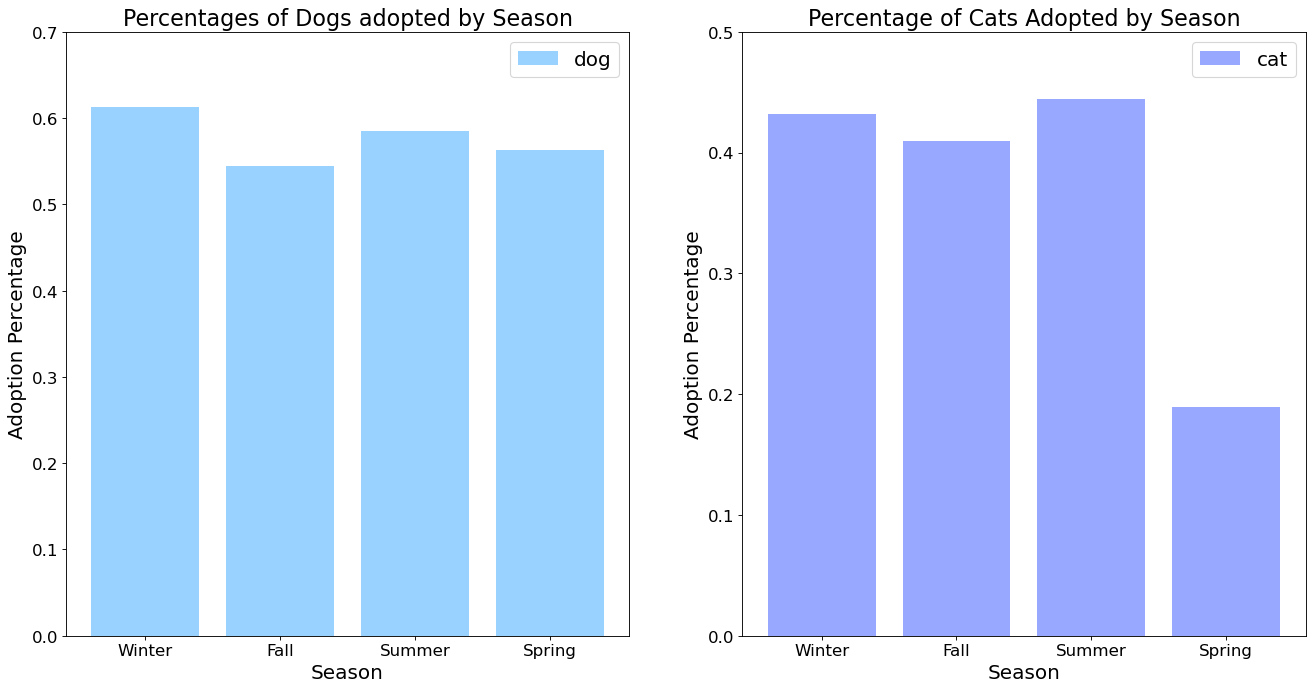

In [24]:
figure(figsize=(20, 10), dpi=80)  
season_names = ["Winter",  "Fall", "Summer", "Spring"]
    
#Dog bar chart
ax = plt.subplot(1,2,1)
plt.bar(season_names, dpercentages, color = "#99d1ff")
plt.title('Percentages of Dogs adopted by Season', fontsize = '20')
plt.xlabel('Season', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.8, 0.1)
plt.xticks(fontsize = '15')
plt.yticks(listOf_Yticks, fontsize = '15')
plt.legend(["dog"], fontsize=18)

#Cat bar chart
ax = plt.subplot(1,2,2)
plt.bar(season_names, updated_cpercentages, color = "#99a8ff")
plt.title('Percentage of Cats Adopted by Season', fontsize = '20')
plt.xlabel('Season', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.6, 0.1)
plt.xticks(fontsize = '15')
plt.yticks(listOf_Yticks, fontsize = '15')
plt.legend(["cat"], fontsize=18)

plt.show()

The final test we performed was to check for any seasonal patterns that could affect adoption rates. When cleaning the data, we took the DateTime of when each animal was adopted or not adopted and converted it into an integer to represent the season. Looking at the dogs, all of the adoption rates are extremely similar for each season. The seasons only differ by a couple of percentage points, so we cannot make any conclusions from this data. The data for the cats is similar, except there is an extremely low adoption rate in the Spring, where it is less than $20\%$. Considering the Spring is the second lowest season in terms of adoption rate for dogs as well, it is fair to say that Spring is not a great month for animals who want to be adopted. 

# Classification


## Process the data again
Breed and Color are String variables, which cannot be accepted by RandomForestClassifier, so we need to process our data again before we run the classification. We used [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from SciKit_learn to transform non-numerical labels into numerical labels.   
In column AnimalType, we used 1 to represent the dog and 0 to represent the cat. In column Gender, we used 1 to represent Neutered Male or Intact Male and 0 to represent Spayed Female, Intact Female, or unknown gender. Now the columns we want to analyze: `Season, AgeuponOutcome(day), AnimalType, Gender, Breed`, and `Color` are all numerical values.

In [25]:
# Create Seperate DataFrame
df2 = df.copy()

# Makes all Males 1, females 0
df2["Gender"] = df.apply(lambda row: 1 if row["SexuponOutcome"] == "Neutered Male" \
                         or row["SexuponOutcome"] ==  "Intact Male"  else 0 , axis=1)
# Makes all Dogs 1 and Cats 0
df2["AnimalType"] = df.apply(lambda row: 1 if row["AnimalType"] == "Dog" else 0 , axis=1)

# Change Breed and Color to numerical values
le = preprocessing.LabelEncoder()
le.fit(df["Breed"])
df2["Breed"] = le.transform(df["Breed"])
le.fit(df["Color"])
df2["Color"] = le.transform(df["Color"])

## Random Forests
A random Forest is a meta-estimator that fits several decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. It is more robust than a single decision, so we used [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from SciKit_learn to make the classification.

In [26]:
# put the data into training and testing parts
data = df2[['Season', 'AgeuponOutcome(day)', 'AnimalType', 'Gender', 'Breed', 'Color']]
target = pd.Series(df2.Adopted)
X, y = data, target
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state = 42)

# use random forests to classify
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# predict
predictions_rf = clf.predict(X_test)

# show the performance metric
print(classification_report(y_test, predictions_rf))
score2 = clf.score(X_test, y_test) 
print("Score for random forests: ", score2)

              precision    recall  f1-score   support

           0       0.70      0.62      0.65      2223
           1       0.64      0.72      0.68      2123

    accuracy                           0.67      4346
   macro avg       0.67      0.67      0.67      4346
weighted avg       0.67      0.67      0.67      4346

Score for random forests:  0.6665899677864703


We got a score of $0.66$, so our model was able to accurately predict $66\%$ of the time whether or not an animal would be adopted based off of the features mentioned above. This model is not perfect, but overall it achieved a good score. 

## Hypothesis Testing
We wanted to test the hypothesis of whether or not “gender” is significant in predicting if the animal becomes adopted or not.   
$H_0:$ gender is not significant  
$H_a:$ gender is significant  
The [feature_importances_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) function provided by SciKit_learn gives us the Gini importance of each variable. Since the Gini score for gender is $0.01895841$, which is a very low score, let's get the p-value of gender and test it at the $1\%$ significance level. When printing out all of the p-values, we see that the p-value corresponding to gender is $2.42657627e-004$, which is $>0.01$. Therefore we fail to reject the null hypothesis and conclude that Gender is not a significant variable when predicting whether or not an animal will be adopted. 

In [27]:
scores, pvalues = chi2(X, y) 
print("p-value: ", pvalues)

p-value:  [1.41974472e-019 0.00000000e+000 5.61162946e-067 2.42657627e-004
 5.45098588e-211 0.00000000e+000]


Using the res

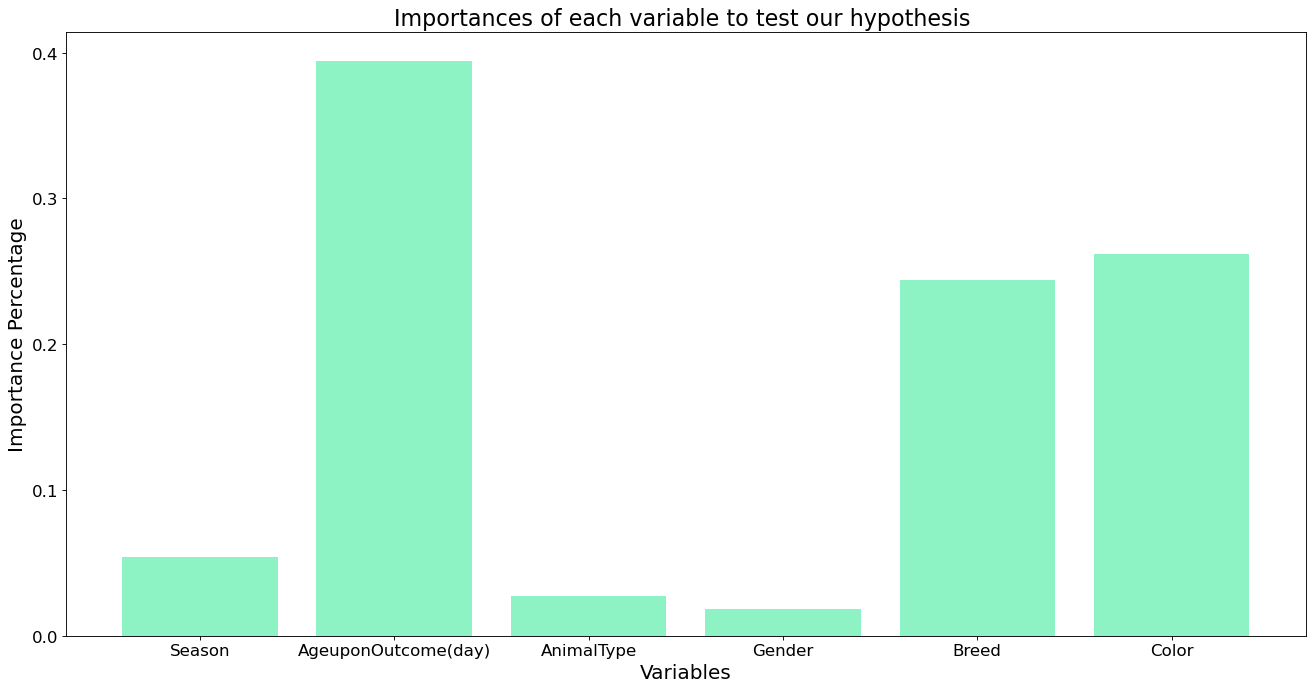

In [28]:
#Find the importances of each variable to test our hypothesis 
figure(figsize=(20, 10), dpi=80)  
features = ['Season', 'AgeuponOutcome(day)', 'AnimalType', 'Gender', 'Breed', 'Color']
#bar chart
plt.bar(features, clf.feature_importances_, color = "#8df2c4")
plt.title('Importances of each variable to test our hypothesis ', fontsize = '20')
plt.xlabel('Variables', fontsize = '18')
plt.ylabel('Importance Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.5, 0.1)
plt.xticks(fontsize = '15')
plt.yticks(listOf_Yticks, fontsize = '15')
plt.show()

 <a id="8"></a> <br>
# Conclusion


From our analysis, some of our major takeaways are that
* Dogs are more likely to be adopted than cats.
* There is a negative relationship between age and the adoption rate of dogs. People prefer teenage (3-12 months) dogs and young (1-2 Years) cats the most out of any age group.
* Cats are least likely to be adopted in Spring.
* When choosing their pets, people care most about the animal’s age, color, and breed, which could be concluded as physical appearance.
* Breeds for both cats and dogs are also significant factors, as there are some breeds of dogs and cats that were more popular than others.

When people are choosing their pets, they consider a lot of different factors, including the animal’s behavior, personality, and so on, which are very difficult to be represented by data. There are many traits and factors regarding animals that were not represented in our initial dataset that contribute to whether or not an animal will be adopted, which helps explain why our Random Forest Classifier did not have better accuracy. Regardless, our project still came up with some useful information regarding our main question: what traits make an animal more or less likely to be adopted?